# Neural Net Language models

> Basic neuralnet-based language modeling 

In [ ]:
#| default_exp models.lm

In [1]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [2]:
#| export
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.optim import SGD
from torch.utils.data import DataLoader

from torchtext.vocab import vocab

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from typing import Dict, List, Tuple, Optional, Set
from collections import Counter, OrderedDict
from dataclasses import dataclass, asdict

from plum import dispatch

from nimrod.text.datasets import CharDataset

/opt/bitnami/python/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Build vocab

In [3]:
#| export
class Vocab:
    def __init__(self,
                 data:List[List[str]], # one line per sentence. each line is a list of tokens
                 specials=['<pad>', '<unk>', '<bos>', '<eos>'] # special characters
                 ):
        # count individual tokens
        c = Counter()
        for row in data:
            for token in row:
                c.update(token)
        ordered_tuple = sorted(c.items(), key=lambda x:x[1], reverse=True)
        dict = OrderedDict(ordered_tuple)        
        # leverage torchtext vocab
        self.voc = vocab(dict, specials=specials)
        if '<unk>' in specials:
            self.voc.set_default_index(self.voc['<unk>'])
        else:
            self.voc.set_default_index(-1)
        self._stoi = self.voc.get_stoi()
        self._itos = self.voc.get_itos()

    @dispatch
    def stoi(self, token:str)->int:
        if len(token) > 1 and token not in ['<pad>', '<unk>', '<bos>', '<eos>']:
            raise ValueError("input should be a token or list of tokens")
        return self._stoi[token]

    @dispatch
    def stoi(self, tokens:List[str])->List[int]:
        return [self._stoi[tok] for tok in tokens]
    
    # @dispatch #TODO
    # def stoi(self, tokens:List[List[str]])->List[List[int]]:
    #     return [self._stoi[u] for tok in tokens for ]
    # TODO:
    # support torch tensors

    @dispatch    
    def itos(self, index:int)->str:
        return self._itos[index]
    
    @dispatch    
    def itos(self, indices:List[int])->List[str]:
        return [self._itos[index] for index in indices]
        
    def __len__(self):
        return len(self.voc)
    
    @property
    def vocabulary(self)->Set:
        return sorted(set([k for k,v in self._stoi.items()]))
    

### Usage

In [4]:
df = pd.read_csv('../data/text/names.txt', header=None, names=['name'])
data = list(df.name)
print(data)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn', 'abigail', 'emily', 'elizabeth', 'mila', 'ella', 'avery', 'sofia', 'camila', 'aria', 'scarlett', 'victoria', 'madison', 'luna', 'grace', 'chloe', 'penelope', 'layla', 'riley', 'zoey', 'nora', 'lily', 'eleanor', 'hannah', 'lillian', 'addison', 'aubrey', 'ellie', 'stella', 'natalie', 'zoe', 'leah', 'hazel', 'violet', 'aurora', 'savannah', 'audrey', 'brooklyn', 'bella', 'claire', 'skylar', 'lucy', 'paisley', 'everly', 'anna', 'caroline', 'nova', 'genesis', 'emilia', 'kennedy', 'samantha', 'maya', 'willow', 'kinsley', 'naomi', 'aaliyah', 'elena', 'sarah', 'ariana', 'allison', 'gabriella', 'alice', 'madelyn', 'cora', 'ruby', 'eva', 'serenity', 'autumn', 'adeline', 'hailey', 'gianna', 'valentina', 'isla', 'eliana', 'quinn', 'nevaeh', 'ivy', 'sadie', 'piper', 'lydia', 'alexa', 'josephine', 'emery', 'julia', 'delilah', 'arianna', 'vivian', 'kaylee', 'sophie', 'brielle', 'madeline', 'peyton', 'ryle

In [5]:
# reading with pandas
df = pd.read_csv('../data/text/names.txt', header=None, names=['name'])
data = list(df.name)

# reading directly in plain python
lines = []
with open('../data/text/tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        if line.strip():
            # only append non blank lines
            lines.append(line)

# add special tokens
data = [['<bos>'] +list(line.strip()) + ['<eos>'] for line in lines]
print(data[:3])

v = Vocab(data)
print(v.stoi('e'))
print(v.itos(8))
print(v.stoi('<pad>'))
print(v.stoi(['e','m']))
print(v.itos([8,17]))
print(len(v))
print(''.join(v.vocabulary))

[['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>'], ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>'], ['<bos>', 'A', 'l', 'l', ':', '<eos>']]
6
t
0
[6, 20]
['t', 'l']
70
 !$&',-.3:;<<bos><eos><pad><unk>>?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [6]:
print(data)

[['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>'], ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>'], ['<bos>', 'A', 'l', 'l', ':', '<eos>'], ['<bos>', 'S', 'p', 'e', 'a', 'k', ',', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>'], ['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>'], ['<bos>', 'Y', 'o', 'u', ' ', 'a', 'r', 'e', ' ', 'a', 'l', 'l', ' ', 'r', 'e', 's', 'o', 'l', 'v', 'e', 'd', ' ', 'r', 'a', 't', 'h', 'e', 'r', ' ', 't', 'o', ' ', 'd', 'i', 'e', ' ', 't', 'h', 'a', 'n', ' ', 't', 'o', ' ', 'f', 'a', 'm', 'i', 's', 'h', '?', '<eos>'], ['<bos>', 'A', 'l', 'l', ':', '<eos>'], ['<bos>', 'R', 'e', 's', 'o', 'l', 'v', 'e', 'd', '.', ' ', 'r', 'e', 's', 'o', 'l', 'v', 'e', 'd', '.', '<eos>'], ['<bos>', 'F', 'i', 'r',

In [7]:
names = list(df.name)
print(len(names), names)

32033 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn', 'abigail', 'emily', 'elizabeth', 'mila', 'ella', 'avery', 'sofia', 'camila', 'aria', 'scarlett', 'victoria', 'madison', 'luna', 'grace', 'chloe', 'penelope', 'layla', 'riley', 'zoey', 'nora', 'lily', 'eleanor', 'hannah', 'lillian', 'addison', 'aubrey', 'ellie', 'stella', 'natalie', 'zoe', 'leah', 'hazel', 'violet', 'aurora', 'savannah', 'audrey', 'brooklyn', 'bella', 'claire', 'skylar', 'lucy', 'paisley', 'everly', 'anna', 'caroline', 'nova', 'genesis', 'emilia', 'kennedy', 'samantha', 'maya', 'willow', 'kinsley', 'naomi', 'aaliyah', 'elena', 'sarah', 'ariana', 'allison', 'gabriella', 'alice', 'madelyn', 'cora', 'ruby', 'eva', 'serenity', 'autumn', 'adeline', 'hailey', 'gianna', 'valentina', 'isla', 'eliana', 'quinn', 'nevaeh', 'ivy', 'sadie', 'piper', 'lydia', 'alexa', 'josephine', 'emery', 'julia', 'delilah', 'arianna', 'vivian', 'kaylee', 'sophie', 'brielle', 'madeline', 'peyton',

## Data formatting
given last n tokens we predict token n+1

In [8]:
s = list("alexandra")
print(s)
bigram = [(x,y) for x, y in zip(s, s[1:])]
print(bigram)
trigram = [ (x,y,z) for x, y, z in zip(s, s[1:], s[2:])]

['a', 'l', 'e', 'x', 'a', 'n', 'd', 'r', 'a']
[('a', 'l'), ('l', 'e'), ('e', 'x'), ('x', 'a'), ('a', 'n'), ('n', 'd'), ('d', 'r'), ('r', 'a')]


In [9]:

def make_dataset(names:List[str], verbose:bool=False, pad_value=0, context_length=3):
    X = []
    y = []
    for name in names:
        s = list(name)
        if verbose:
            print('row: ', s)
        # init prefix with padding while len < context_length
        for i in range(context_length-1):
            sequence = v.stoi(s[:i+1])
            pad_len = context_length - len(sequence)
            pad = [pad_value] * pad_len
            X.append(pad + sequence)
            y.append(v.stoi(s[i+1]))

            if verbose:
                print(pad+s[:i+1], s[i+1])

        # for length seq = context_length
        i = 0
        while i < (len(s) - context_length):
            X.append(v.stoi(s[i:context_length+i]))
            y.append(v.stoi(s[i+context_length]))
            if verbose:
                print(s[i:context_length+i], s[i+context_length])
            i += 1
    return torch.tensor(X),torch.tensor(y)


In [10]:
CONTEXT_LEN = 2

X, y = make_dataset(data[:1], verbose=True, pad_value=v.stoi('<pad>'), context_length=CONTEXT_LEN)
print(X.shape, y.shape)

row:  ['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>']
[0, '<bos>'] F
['<bos>', 'F'] i
['F', 'i'] r
['i', 'r'] s
['r', 's'] t
['s', 't']  
['t', ' '] C
[' ', 'C'] i
['C', 'i'] t
['i', 't'] i
['t', 'i'] z
['i', 'z'] e
['z', 'e'] n
['e', 'n'] :
['n', ':'] <eos>
torch.Size([15, 2]) torch.Size([15])


## MLP Model
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [ ]:
# F.one_hot(torch.tensor(5), num_classes=n_vocab).float()@C # == C[5]

In [11]:
#| export

@dataclass
class NNLMConfig:
    n_vocab:int = 30
    n_emb:int = 10
    n_context:int = 3
    n_h:int = 100

class NNLM(nn.Module):
    def __init__(self,
                n_vocab:int, # vocabulary size 
                n_emb:int, # embedding dimension
                n_context:int, # context size bigram/trigram, etc.
                n_h:int # hidden layer size
                ):
        super().__init__()
        # to each token id from n_vocab in sequence T coresponds a embedding of size n_emb (C)
        self.embedder = nn.Embedding(n_vocab, n_emb) # (B,T)->(B,T,C)
        self.n_emb = n_emb
        self.n_context = n_context
        # we concatenate input of n_context length * n_emb (T*C) into linear layer:
        self.l1 = nn.Linear(n_emb*n_context, n_h) 
        self.l2 = nn.Linear(n_h, n_vocab)
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        # input: (B,T)
        embedding = self.embedder(x) # ->(B,T,C)
        # we concatenate input of n_context length * n_emb (T*C) into linear layer:
        h = self.l1(embedding.view(-1, self.n_emb*self.n_context))
        h = torch.tanh(h)
        logits = self.l2(h)
        return(logits)
    
    def sample(self, n_iterations:int=10, eos:int=3, pad:int=0, bos:int=2)->str:
        res = []
        for _ in range(n_iterations):
            out = [] # current sequence prediction
            context = [pad] * (self.n_context-1) + [bos]
            while True:
                logits = self(torch.tensor([context]))
                probs = F.softmax(logits, dim=1)
                ix = torch.multinomial(probs, num_samples=1).item()
                context = context[1:] + [ix]
                if ix == eos:
                    break
                else:
                    out.append(ix)
            res.append(out)
        return(res)

### Usage

In [12]:
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM(**asdict(conf))
n_samples = 25
x = torch.randint(conf.n_vocab, (n_samples, conf.n_context))
print(x.shape)
y = lm(x)
print(y.shape)

torch.Size([25, 2])
torch.Size([25, 70])


### Basic training loop

In [13]:
n1 = int(0.8*len(data))
n2 = int(0.9*len(data))
Xtr, Ytr = make_dataset(data[:80],context_length=CONTEXT_LEN)
Xdev, Ydev = make_dataset(data[80:90])
Xte, Yte = make_dataset(data[90:100])
print(Xtr.shape, Ytr.shape)

torch.Size([2703, 2]) torch.Size([2703])


In [14]:
# overfit one batch
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []

iter_max = 1
for i in range(iter_max):
    optim.zero_grad()
    logits = lm(Xtr)
    loss = F.cross_entropy(logits, Ytr)
    loss.backward()
    optim.step()
    train_loss.append(loss.item())
    if not(i%1000):
        print(loss.item())

4.275121688842773


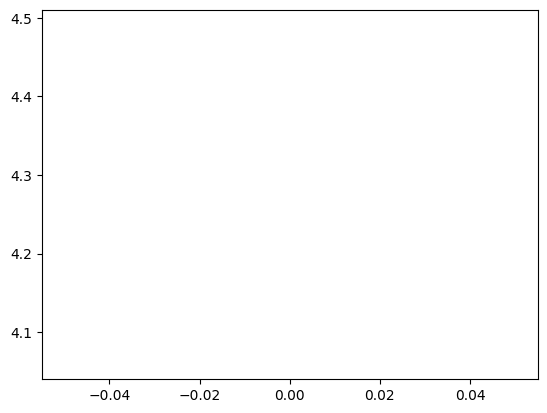

In [15]:
plt.plot(train_loss)

### Sample

In [16]:
eos = v.stoi('<eos>')
bos = v.stoi('<bos>')
pad = v.stoi('<pad>')
sequences = lm.sample(n_iterations=20,bos=bos, eos=eos, pad=pad)
for seq in sequences:
    print(''.join(v.itos(i) for i in seq))

COcFe:GhkPXS;d&xaeZg<pad>JQ;'HWJvwm<pad>Oz,QFfB;X;E$ '<unk>Omj,mmpq
A<pad><pad>GS<pad>';>aVKWu;dR3D'N3QQLllLMY3bfotXVFv<unk>tzUkc!PPL3G'$t,?OdvwXNf
<pad>zOEjhEQOs,&NE NOxEdj nEUq-d&TuK?fTwdCIazeDZEjV s$LV
RP.I<g'bvC-:kNl<JoDYd<unk>WtFnJE-JDRx
US<pad>EJ;GLvpEKjU<UGEsx3v<bos>O<unk>Ewp3ymvB;ZF3wMn?zackoG:<unk>
!B<bos>fcxrC'ygmeycqGC!P>GA<unk>;Dk<bos>Zsh<<FNR:<pad>?NRZ.ovksvqKxroH'&Uhd$R-
oya?J'Iyd!,>ZKrJt$xJI-Rb<LLAHisznb'D<pad>lbCRvH<pad><<SXW>;>kwUMa<pad>smet<pad>&BJ<unk>H.$!<lUJeNvcaB:-<unk>tiM'fI<qjVVxGriELTUjM!X<unk>-<unk>P?&'x: YmI:B&UT>pb<bos>K:o!BGkHEVbYc;h; jn<pad>japbc'D
zNXE<unk>pmtuRt.aa
tY>n3PeLEoQUWXWI,TVZAYj&TXKwf&VVMDGLGA<<pad>TZLTahrCzA!Hl$gUSvTcGx?GjISDW.RkKo-v? ug
 CXN.DS.!:ke bWRji3Xsn::hj
BIcrzTrw:!CcI>PqU:<unk>V<bos>d?SuwtZblZfx;,;vps<bos>DFfPu<bos>T-xPe:al RrDgCt
Tj<<unk>Goxo i.<bos>St<unk>lpL,N!ROjrf;.dYHqkG!lvxZuMQCKVoBGE-X<unk>$im-yi!VgGyESM<pad>EJFsLMk,X&yqrK
:cfOOg'hGE3MlmeGV3Juo<pad>'e<fP>X!$YpR<unk>VK;BVBRwy::aYBx
;mZ?-QC<unk>YE,zmvDgVBj$B<unk><v:kHu&hPoV,x?O

## NN Bigram

In [17]:
#| export

class NNBigram(nn.Module):
    def __init__(self, vocab_size:int) -> None:
        super().__init__()
        self.emb = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x:torch.tensor) -> torch.tensor:
        logits = self.emb(x) # B,T,C
        return logits
    
    def predict(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits = self(idx)
            logits = logits[:,-1,:] # last time step
            probs = F.softmax(logits, dim=-1) #(B,C)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


### Usage

In [18]:
B, T, C = 32, 8, 65
vocab_size = C
model = NNBigram(vocab_size)
X = torch.randint(0,C,(B,T))
logits = model(X) # (B, T, C)
print(logits.shape)

torch.Size([32, 8, 65])


In [19]:
# generate
model.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=100)[0]

tensor([ 0, 64,  2,  3,  4,  1, 49, 20, 62, 32, 48, 53, 11, 48, 31, 28, 28, 32,
        20, 38, 52, 15, 37, 38, 16,  4, 16,  5, 52, 25, 28,  7, 50, 57, 17, 25,
        60, 21,  6, 46, 57, 17, 59, 57, 51, 46, 30, 22, 43, 42, 59, 35, 34, 40,
        39, 13,  6, 30, 16, 27, 49, 16, 19, 43,  9, 36, 11, 36,  7, 62, 46, 48,
        53, 47, 36,  7,  8,  5, 52, 24, 25,  1, 22, 29, 54, 10, 38, 17, 30, 37,
         2,  3, 55, 18, 29, 44, 42, 47, 41, 16, 38])

### Data

In [20]:
with open('../data/text/tiny_shakespeare.txt') as f:
    text = f.read()

In [21]:
# dataset
block_size = 8
ds = CharDataset(text, block_size)
X,Y = ds[0]
print("x:",  ds.from_tokens(X), "\ny:", ds.from_tokens(Y))

x: onder is 
y: nder is 


In [22]:
# dataloader
dl = DataLoader(ds, batch_size=32, num_workers=0)
X, Y = next(iter(dl))
print("x:", X.shape, "\ny:", Y.shape)

x: torch.Size([32, 8]) 
y: torch.Size([32, 8])


### Training

In [23]:
model = NNBigram(ds.vocab_size)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
device = torch.device('cpu')

In [25]:
%%time
n_epochs = 1
train_loss = []
for epoch in range(n_epochs):
    model.train()
    X = X.to(device) # (B,T)
    Y = Y.to(device) # (B,T)
    logits = model(X)
    B, T, C = logits.shape
    loss = criterion(logits.view(B*T, C), Y.view(B*T))
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    if not(epoch % 1000):
        print(loss.item())

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        logits = model(X).view(B*T,C) 
        # _, predicted = torch.max(logits.data, 1)
        probs = F.softmax(logits, dim=-1)
        # print("probs: ", probs.shape)
        preds = torch.argmax(probs, dim=1)
        # print("pred:", preds.shape)
        # print("Y:", Y.shape)
        # print(predicted)
        # total += Y.size(0)
        # correct += (predicted == Y).sum()
        # print(f"Epoch {epoch + 1}: Accuracy = {100 * correct / total:.2f}%")

4.638984203338623
CPU times: user 8.94 ms, sys: 3.48 ms, total: 12.4 ms
Wall time: 2.35 ms


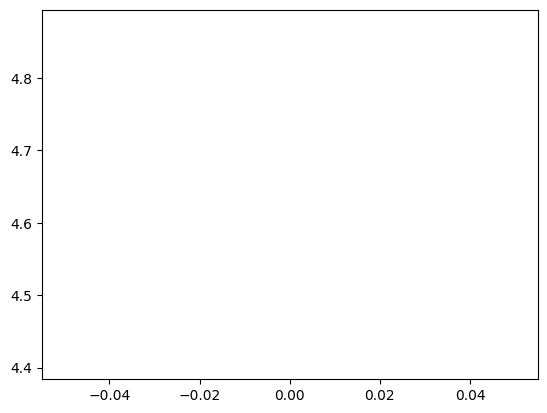

In [26]:
plt.plot(train_loss)

In [27]:
print(ds.from_tokens(model.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

Zk:3vz,:wlFCsCJlhUoSr,Dmb$?J,&MyYrQtgQdEa'vvS?Joiz:!MRwXFU l3mbp.b3O?
ON,3lvDkq$nUJv i-.-C3OaPfcp.S?oWzQsGiDsf!:ZTJWh
WsEi-!UnAsQTumvr!nHvYHywz$VEG,FI!CZ3A.gGMnwlWpLS
rGNCr
.rZVjSvx.BO?&XsGGyFQrRDMQ'U'CuihopOKNDQ;zy$YLxFkPZASDj& VUsHjg!bmlbYHcdZIb!cYkyHTzEv3O!yFoumLn:p;OSVF:YounSP-:u J'T?cmpVNZH CWnU$nMmLS;XI&A'cKN,nDZOt$'KR-yEGyNvl?BQ,lWqtTU3
NM&mbXIWdmh!Joi:DmHHBxgG,On? i-SZ
 VEl3EtSIKPhzRvhq$VzbFTLEFM!DN?qNVGPWeK3ah'ua-VbY$mHU Nz
VG-WT;i$t;$nU?h?&QcKsEQehP,iexCC-.;YWZ-ma.X'H-.zb3l3PVzK'CuS?Bxy


In [28]:
#| hide
import nbdev; nbdev.nbdev_export()